## Setup

In [1]:
# Packages
import pandas as pd
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pylab
import math

In [2]:
# Import data
tor_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_train_set_no_zeros.csv")


# Quick inspection
tor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4732 entries, 0 to 4731
Data columns (total 29 columns):
EVENT_ID              4732 non-null int64
INJURIES_DIRECT       4732 non-null int64
DEATHS_DIRECT         4732 non-null int64
DAMAGE_PROPERTY       4732 non-null float64
DAMAGE_CROPS          4732 non-null float64
DURATION_SECONDS      4732 non-null float64
BEGIN_LAT             4732 non-null float64
BEGIN_LON             4732 non-null float64
TOR_LENGTH            4732 non-null float64
TOR_WIDTH             4732 non-null float64
BEGIN_DATE_TIME       4732 non-null float64
YEAR                  4732 non-null int64
CZ_NAME               4732 non-null object
STATE                 4732 non-null object
OPEN_WATER_PROP       4732 non-null float64
DEV_OPEN_PROP         4732 non-null float64
DEV_LOW_PROP          4732 non-null float64
DEV_MED_PROP          4732 non-null float64
DEV_HIGH_PROP         4732 non-null float64
DECID_FOREST_PROP     4732 non-null float64
EVERGR_FOREST_PROP    4

In [3]:
# Seperating variables
# The dependent variables
tornado_outcomes = tor_df.iloc[:, [3]]


# Quick inspection
tornado_outcomes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4732 entries, 0 to 4731
Data columns (total 1 columns):
DAMAGE_PROPERTY    4732 non-null float64
dtypes: float64(1)
memory usage: 37.0 KB


In [4]:
# The independent variables
tornado_features = tor_df.iloc[:, 5:]


# Get rid of year and county name
tornado_features = tornado_features.drop(["YEAR",
                                          "CZ_NAME",
                                          "STATE"],
                                         axis = 1)



# Quick inspection
tornado_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4732 entries, 0 to 4731
Data columns (total 21 columns):
DURATION_SECONDS      4732 non-null float64
BEGIN_LAT             4732 non-null float64
BEGIN_LON             4732 non-null float64
TOR_LENGTH            4732 non-null float64
TOR_WIDTH             4732 non-null float64
BEGIN_DATE_TIME       4732 non-null float64
OPEN_WATER_PROP       4732 non-null float64
DEV_OPEN_PROP         4732 non-null float64
DEV_LOW_PROP          4732 non-null float64
DEV_MED_PROP          4732 non-null float64
DEV_HIGH_PROP         4732 non-null float64
DECID_FOREST_PROP     4732 non-null float64
EVERGR_FOREST_PROP    4732 non-null float64
MIXED_FOREST_PROP     4732 non-null float64
SHRUB_SCRUB_PROP      4732 non-null float64
GRASS_LAND_PROP       4732 non-null float64
PASTURE_HAY_PROP      4732 non-null float64
CULT_CROPS_PROP       4732 non-null float64
WOOD_WETLAND_PROP     4732 non-null float64
HERB_WETLAND_PROP     4732 non-null float64
BARREN_LAND_P

In [5]:
# Make the dependent variables into a numpy array
outcomes_array = tornado_outcomes.values


# Makes the numpy array into a torch Tensor
outcomes_Tensor = torch.from_numpy(outcomes_array)


# Quick inspection
outcomes_Tensor


 0.5951
 1.2772
 0.6926
   ⋮    
 0.7159
 0.8757
 0.4558
[torch.DoubleTensor of size 4732x1]

In [6]:
# Make the independent variables into a numpy array
features_array = tornado_features.values


# Make the numpy array into a torch Tensor
features_Tensor = torch.from_numpy(features_array)


# Quick inspection
features_Tensor


 1.9605e-01  3.8572e-01 -7.9828e-01  ...  -4.6545e-02 -2.1285e-01 -6.9525e-01
-1.4814e-02  1.8039e-01  9.5833e-01  ...  -1.2423e+00 -9.0635e-01  2.2024e+00
 5.5754e-01 -1.0135e+00  7.6543e-01  ...   1.4441e+00  1.6766e+00 -6.9525e-01
                ...                   ⋱                   ...                
 9.6160e-01  6.1517e-02  4.1479e-01  ...  -1.5462e-01 -9.0635e-01 -6.9525e-01
 8.2443e-01  3.3896e-02  5.4983e-01  ...   3.4848e-01  3.6783e-01  1.1558e+00
-3.7344e-01 -7.4953e-01  9.0271e-01  ...  -6.3764e-01 -9.0635e-01  6.8160e-01
[torch.DoubleTensor of size 4732x21]

### Convert DoubleTensor to FloatTensor

In [7]:
# Changing dependent variables from a DoubleTensor to a FloatTensor
outcomes_Tensor = outcomes_Tensor.float()


# ...and for the independent variables
features_Tensor = features_Tensor.float()


# Quick check
features_Tensor


 1.9605e-01  3.8572e-01 -7.9828e-01  ...  -4.6545e-02 -2.1285e-01 -6.9525e-01
-1.4814e-02  1.8039e-01  9.5833e-01  ...  -1.2423e+00 -9.0635e-01  2.2024e+00
 5.5754e-01 -1.0135e+00  7.6543e-01  ...   1.4441e+00  1.6766e+00 -6.9525e-01
                ...                   ⋱                   ...                
 9.6160e-01  6.1517e-02  4.1479e-01  ...  -1.5462e-01 -9.0635e-01 -6.9525e-01
 8.2443e-01  3.3896e-02  5.4983e-01  ...   3.4848e-01  3.6783e-01  1.1558e+00
-3.7344e-01 -7.4953e-01  9.0271e-01  ...  -6.3764e-01 -9.0635e-01  6.8160e-01
[torch.FloatTensor of size 4732x21]

## Round 1: One-Hidden-Layer Neural Network

In [8]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [9]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(21, 14),
                            torch.nn.ReLU(),
                            torch.nn.Linear(14, 1))

In [10]:
# Set the loss function
loss_fn = torch.nn.MSELoss(size_average=False)

In [11]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 4e-6


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    model.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using gradient descent
    for param in model.parameters():
        param.data -= learning_rate * param.grad.data

In [12]:
# Get the iterations
iterations = list(range(0, 10000))

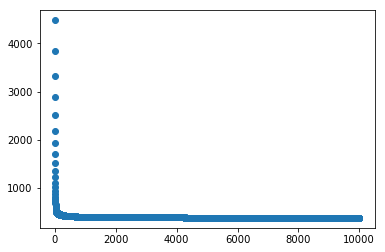

In [13]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors)

In [14]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(4732)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

In [15]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
outcomes_Variable_resized = outcomes_Variable.resize(4732)


# Make the FloatTensor into a numpy.array
outcomes_array = outcomes_Variable_resized.data.numpy()


# Make the numpy.array into a list
outcomes_list = outcomes_array.tolist()

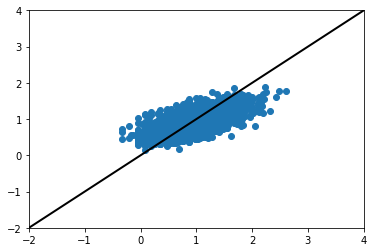

In [16]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 1.1: Validation Set Performance

In [17]:
# Import data
valid_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_cv_set_no_zeros.csv")


# Validation set outcomes
valid_outcomes = valid_df.iloc[:, [3]]


# Make the validation outcomes into a numpy array
valid_outcomes_array = valid_outcomes.values


# Makes the numpy array into a torch Tensor
valid_outcomes_Tensor = torch.from_numpy(valid_outcomes_array)


# Changing validation outcomes from a DoubleTensor to a FloatTensor
valid_outcomes_Tensor = valid_outcomes_Tensor.float()


# Make the Tensor into a Pytorch Variable
valid_outcomes_Variable = Variable(valid_outcomes_Tensor)

In [18]:
# Validation set predictors
valid_predictors = valid_df.iloc[:, 5:]

valid_predictors = valid_predictors.drop(["YEAR",
                                          "CZ_NAME",
                                          "STATE"],
                                         axis = 1)


# Make the validation predictors into a numpy array
valid_predictors_array = valid_predictors.values


# Makes the numpy array into a torch Tensor
valid_predictors_Tensor = torch.from_numpy(valid_predictors_array)


# Changing validation predictors from a DoubleTensor to a FloatTensor
valid_predictors_Tensor = valid_predictors_Tensor.float()


# Make the Tensor into a Pytorch Variable
valid_predictors_Variable = Variable(valid_predictors_Tensor)

In [19]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model = torch.nn.Sequential(torch.nn.Linear(21, 14),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(14, 1))


# Give the new model the old model's parameters
dim_corrected_model[(0)].weight = model[(0)].weight
dim_corrected_model[(2)].weight = model[(2)].weight

In [20]:
# Get the validation set predictions
y_valid_pred = dim_corrected_model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 591.2800
[torch.FloatTensor of size 1]

In [21]:
valid_predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1619 entries, 0 to 1618
Data columns (total 21 columns):
DURATION_SECONDS      1619 non-null float64
BEGIN_LAT             1619 non-null float64
BEGIN_LON             1619 non-null float64
TOR_LENGTH            1619 non-null float64
TOR_WIDTH             1619 non-null float64
BEGIN_DATE_TIME       1619 non-null float64
OPEN_WATER_PROP       1619 non-null float64
DEV_OPEN_PROP         1619 non-null float64
DEV_LOW_PROP          1619 non-null float64
DEV_MED_PROP          1619 non-null float64
DEV_HIGH_PROP         1619 non-null float64
DECID_FOREST_PROP     1619 non-null float64
EVERGR_FOREST_PROP    1619 non-null float64
MIXED_FOREST_PROP     1619 non-null float64
SHRUB_SCRUB_PROP      1619 non-null float64
GRASS_LAND_PROP       1619 non-null float64
PASTURE_HAY_PROP      1619 non-null float64
CULT_CROPS_PROP       1619 non-null float64
WOOD_WETLAND_PROP     1619 non-null float64
HERB_WETLAND_PROP     1619 non-null float64
BARREN_LAND_P

In [22]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(1619)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

In [23]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
valid_outcomes_Variable_resized = valid_outcomes_Variable.resize(1619)


# Make the FloatTensor into a numpy.array
valid_outcomes_array = valid_outcomes_Variable_resized.data.numpy()


# Make the numpy.array into a list
valid_outcomes_list = valid_outcomes_array.tolist()

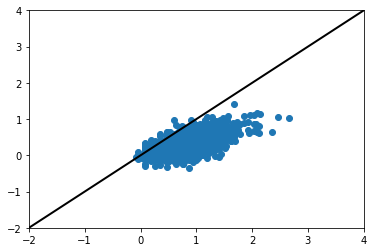

In [24]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 1.2: Test Set Performance

In [25]:
# Import data
test_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_test_set_no_zeros.csv")


# Validation set outcomes
test_outcomes = test_df.iloc[:, [3]]


# Make the validation outcomes into a numpy array
test_outcomes_array = test_outcomes.values


# Makes the numpy array into a torch Tensor
test_outcomes_Tensor = torch.from_numpy(test_outcomes_array)


# Changing validation outcomes from a DoubleTensor to a FloatTensor
test_outcomes_Tensor = test_outcomes_Tensor.float()


# Make the Tensor into a Pytorch Variable
test_outcomes_Variable = Variable(test_outcomes_Tensor)

In [26]:
# Validation set predictors
test_predictors = test_df.iloc[:, 5:]

test_predictors = test_predictors.drop(["YEAR",
                                        "CZ_NAME",
                                        "STATE"],
                                       axis = 1)


# Make the validation predictors into a numpy array
test_predictors_array = test_predictors.values


# Makes the numpy array into a torch Tensor
test_predictors_Tensor = torch.from_numpy(test_predictors_array)


# Changing validation predictors from a DoubleTensor to a FloatTensor
test_predictors_Tensor = test_predictors_Tensor.float()


# Make the Tensor into a Pytorch Variable
test_predictors_Variable = Variable(test_predictors_Tensor)

In [27]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model_2 = torch.nn.Sequential(torch.nn.Linear(21, 14),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(14, 1))


# Give the new model the old model's parameters
dim_corrected_model_2[(0)].weight = model[(0)].weight
dim_corrected_model_2[(2)].weight = model[(2)].weight

In [28]:
# Get the validation set predictions
y_test_pred = dim_corrected_model_2(test_predictors_Variable)


# Print the loss
loss_fn(y_test_pred,
        test_outcomes_Variable)

Variable containing:
 405.0779
[torch.FloatTensor of size 1]

In [29]:
test_predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1609 entries, 0 to 1608
Data columns (total 21 columns):
DURATION_SECONDS      1609 non-null float64
BEGIN_LAT             1609 non-null float64
BEGIN_LON             1609 non-null float64
TOR_LENGTH            1609 non-null float64
TOR_WIDTH             1609 non-null float64
BEGIN_DATE_TIME       1609 non-null float64
OPEN_WATER_PROP       1609 non-null float64
DEV_OPEN_PROP         1609 non-null float64
DEV_LOW_PROP          1609 non-null float64
DEV_MED_PROP          1609 non-null float64
DEV_HIGH_PROP         1609 non-null float64
DECID_FOREST_PROP     1609 non-null float64
EVERGR_FOREST_PROP    1609 non-null float64
MIXED_FOREST_PROP     1609 non-null float64
SHRUB_SCRUB_PROP      1609 non-null float64
GRASS_LAND_PROP       1609 non-null float64
PASTURE_HAY_PROP      1609 non-null float64
CULT_CROPS_PROP       1609 non-null float64
WOOD_WETLAND_PROP     1609 non-null float64
HERB_WETLAND_PROP     1609 non-null float64
BARREN_LAND_P

In [30]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_test_pred_resized = y_test_pred.resize(1609)


# Make the FloatTensor into a numpy.array
y_test_pred_array = y_test_pred_resized.data.numpy()


# Convert back to native units and scale
y_test_pred_array = y_test_pred_array*5.735285 + 6.490682


# Make the numpy.array into a list
y_test_pred_list = y_test_pred_array.tolist()

In [31]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
test_outcomes_Variable_resized = test_outcomes_Variable.resize(1609)


# Make the FloatTensor into a numpy.array
test_outcomes_array = test_outcomes_Variable_resized.data.numpy()


# Convert back to native units and scale
test_outcomes_array = test_outcomes_array*5.735285 + 6.490682


# Make the numpy.array into a list
test_outcomes_list = test_outcomes_array.tolist()

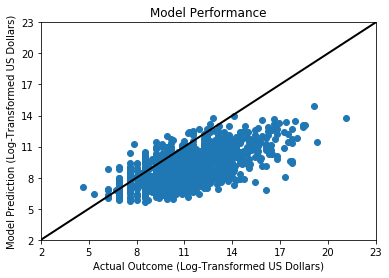

In [32]:
# Plot new predictions versus new data outcomes

plt.scatter(test_outcomes_list, y_test_pred_list)

axes = plt.gca()

axes.set_xlim([2, 23])

axes.set_ylim([2, 23])

axes.set_xticks([2, 5, 8, 11, 14, 17, 20, 23])

axes.set_yticks([2, 5, 8, 11, 14, 17, 20, 23])

plt.plot([2, 23], [2, 23], 'k-', lw=2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [33]:
dim_corrected_model_2[(0)].weight

Parameter containing:

Columns 0 to 9 
-0.0576 -0.0931  0.0525  0.1220 -0.1031  0.0257  0.0719 -0.1138 -0.0261  0.2111
 0.0930  0.0557 -0.0605  0.1435  0.1986  0.0335  0.0003  0.1641  0.1803  0.0652
-0.0600 -0.0590  0.0592  0.1352  0.2797 -0.0841 -0.0472  0.1089  0.2007  0.0070
-0.0010  0.0290  0.2179  0.0971  0.1826 -0.0912  0.2394 -0.0577  0.0833 -0.1369
-0.1895  0.1013  0.0176 -0.1752 -0.0989  0.0876  0.1048 -0.1017 -0.0196  0.0932
 0.0766 -0.1348  0.0783 -0.2290  0.0093  0.0751  0.0614 -0.2067  0.0054  0.0248
 0.0919 -0.1966 -0.0584  0.0799  0.2466 -0.0350  0.1248 -0.0979  0.0091  0.1382
-0.0811 -0.0844  0.1258  0.2653 -0.0652  0.0006 -0.0381  0.0678 -0.0153 -0.0709
-0.1183  0.1943 -0.1294 -0.2032 -0.1973  0.1187 -0.2020 -0.0401  0.0483 -0.0712
-0.0197  0.1296 -0.0266 -0.0680  0.1446  0.1639 -0.1384 -0.1024  0.0958  0.0525
 0.1974  0.2079  0.0287  0.1032  0.1649 -0.0597 -0.0270 -0.2371  0.1195  0.0464
-0.0092  0.0466  0.1518  0.1840  0.2643 -0.0480 -0.0751  0.0162  0.0171  0.0717
 

In [34]:
dim_corrected_model_2[(2)].weight

Parameter containing:

Columns 0 to 9 
-0.1838  0.1325  0.0533  0.0873 -0.1282 -0.0761  0.2873  0.1163 -0.0507 -0.0055

Columns 10 to 13 
 0.2005  0.2266  0.0422 -0.0543
[torch.FloatTensor of size 1x14]

## Round 2: Two-Hidden-Layer Neural Network

In [35]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [36]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(21, 14),
                            torch.nn.ReLU(),
                            torch.nn.Linear(14, 9),
                            torch.nn.ReLU(),
                            torch.nn.Linear(9, 1))

In [37]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 6e-6


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    model.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using gradient descent
    for param in model.parameters():
        param.data -= learning_rate * param.grad.data

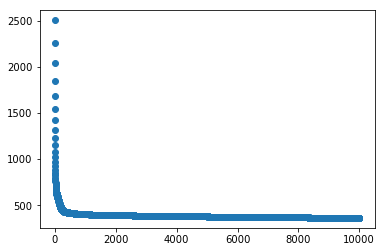

In [38]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors)

In [39]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(4732)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

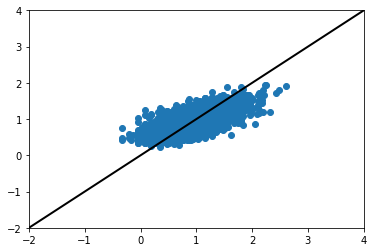

In [40]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 2.1: Validation Set Performance

In [41]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model = torch.nn.Sequential(torch.nn.Linear(21, 14),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(14, 9),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(9, 1))


# Give the new model the old model's parameters
dim_corrected_model[(0)].weight = model[(0)].weight
dim_corrected_model[(2)].weight = model[(2)].weight
dim_corrected_model[(4)].weight = model[(4)].weight

In [42]:
# Get the validation set predictions
y_valid_pred = dim_corrected_model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 1009.2942
[torch.FloatTensor of size 1]

In [43]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(1619)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

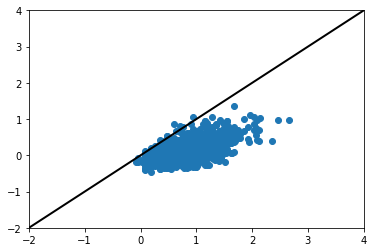

In [44]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 2.2: Test Set Performance

In [45]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model_2 = torch.nn.Sequential(torch.nn.Linear(21, 14),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(14, 9),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(9, 1))


# Give the new model the old model's parameters
dim_corrected_model_2[(0)].weight = model[(0)].weight
dim_corrected_model_2[(2)].weight = model[(2)].weight
dim_corrected_model_2[(4)].weight = model[(4)].weight

In [46]:
# Get the validation set predictions
y_test_pred = dim_corrected_model_2(test_predictors_Variable)


# Print the loss
loss_fn(y_test_pred,
        test_outcomes_Variable)

Variable containing:
 965.9709
[torch.FloatTensor of size 1]

In [47]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_test_pred_resized = y_test_pred.resize(1609)


# Make the FloatTensor into a numpy.array
y_test_pred_array = y_test_pred_resized.data.numpy()


# Convert back to native units and scale
y_test_pred_array = y_test_pred_array*5.735285 + 6.490682


# Make the numpy.array into a list
y_test_pred_list = y_test_pred_array.tolist()

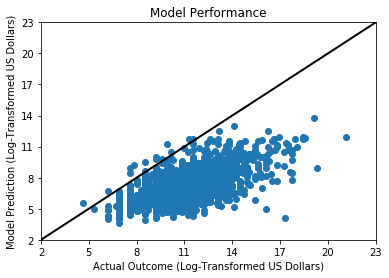

In [48]:
# Plot new predictions versus new data outcomes

plt.scatter(test_outcomes_list, y_test_pred_list)

axes = plt.gca()

axes.set_xlim([2, 23])

axes.set_ylim([2, 23])

axes.set_xticks([2, 5, 8, 11, 14, 17, 20, 23])

axes.set_yticks([2, 5, 8, 11, 14, 17, 20, 23])

plt.plot([2, 23], [2, 23], 'k-', lw=2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [49]:
dim_corrected_model_2[(0)].weight

Parameter containing:

Columns 0 to 9 
-0.1812  0.0424 -0.0574 -0.3198  0.0156  0.1023  0.1352 -0.2457  0.0315 -0.0290
-0.1316 -0.1086  0.1808  0.0834 -0.0790  0.1701 -0.0532  0.2020 -0.0793  0.1649
-0.0437  0.0780  0.0925  0.0791 -0.0138 -0.2540 -0.0236 -0.0829 -0.1295  0.1234
 0.1402 -0.0493 -0.0018  0.2565  0.3929  0.0586 -0.0242 -0.0890  0.1816  0.2162
 0.1662 -0.1012  0.0896  0.0317 -0.0777  0.1175 -0.0435 -0.0527 -0.0379  0.0168
 0.0764 -0.1841 -0.1815 -0.0695  0.2247  0.1021 -0.0594 -0.1316 -0.0084  0.0096
 0.1203  0.2125  0.0099  0.1612  0.3553 -0.1358  0.0155 -0.0237  0.2029  0.0757
 0.0083  0.0197  0.1241  0.0552 -0.3256  0.0597 -0.0554  0.0370 -0.1365 -0.0053
 0.0513  0.0537  0.1606  0.1170  0.1811 -0.0524 -0.0040 -0.1701  0.0819 -0.2171
 0.2754 -0.2067  0.1095  0.2854  0.0506 -0.0793  0.0857 -0.1289 -0.1040  0.1215
-0.1356 -0.1722  0.0456 -0.0771  0.1063  0.0403  0.0528 -0.0373 -0.0281  0.2403
 0.0774 -0.1169 -0.0728 -0.1451  0.0952 -0.0503  0.2446 -0.1688 -0.0020  0.1708
 

In [50]:
dim_corrected_model_2[(2)].weight

Parameter containing:

Columns 0 to 9 
 0.1888  0.0767 -0.0591 -0.0274 -0.0986 -0.1818 -0.4513  0.2146 -0.2693  0.2817
-0.0242  0.1660 -0.0763  0.2531 -0.2060 -0.2337  0.0233 -0.3164  0.1316  0.1666
 0.0141 -0.0309  0.2567 -0.1112  0.2076  0.2513  0.1018  0.1355  0.0523 -0.0160
 0.2602  0.2000  0.0972 -0.0367  0.0375  0.1023 -0.1159 -0.1746 -0.0154 -0.0589
-0.1496 -0.0939 -0.0694  0.2653 -0.1694  0.1899  0.0064  0.2636  0.1132  0.1874
 0.1389  0.0676 -0.0726 -0.1513 -0.0488 -0.0778 -0.1466 -0.1742  0.0134 -0.2510
-0.1711 -0.1191 -0.1685  0.1629 -0.0729 -0.1470  0.1709 -0.2217  0.0473 -0.1643
 0.0011 -0.1426 -0.1255  0.0810 -0.1907 -0.1352  0.0483 -0.2639  0.0782 -0.0202
-0.1667  0.1864 -0.2505 -0.1951 -0.2181  0.1909 -0.1391 -0.0260  0.0436  0.1164

Columns 10 to 13 
 0.2726  0.2059  0.1927  0.0063
 0.0978  0.2970  0.2241  0.2773
 0.1737 -0.0089 -0.1902  0.1267
-0.1280  0.1663  0.0524  0.1583
 0.2057  0.1433  0.0717 -0.0580
 0.2502 -0.0805 -0.1045  0.2111
-0.1914  0.2328  0.1787 -0.025

In [51]:
dim_corrected_model_2[(4)].weight

Parameter containing:
-0.5088  0.6454 -0.1356 -0.1986  0.2102 -0.0015  0.3028 -0.1143  0.1383
[torch.FloatTensor of size 1x9]

## Round 3: Three-Hidden-Layers Neural Network

In [52]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [53]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(21, 14),
                            torch.nn.ReLU(),
                            torch.nn.Linear(14, 9),
                            torch.nn.ReLU(),
                            torch.nn.Linear(9, 6),
                            torch.nn.ReLU(),
                            torch.nn.Linear(6, 1))

In [54]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 5e-6


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    model.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using gradient descent
    for param in model.parameters():
        param.data -= learning_rate * param.grad.data

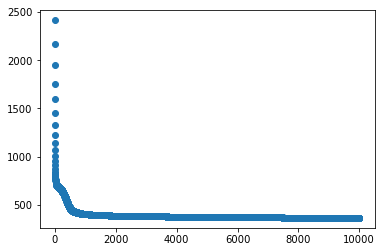

In [55]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors)

In [56]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(4732)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

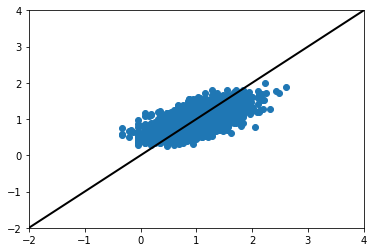

In [57]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 3.1: Validation Set Performance

In [58]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model = torch.nn.Sequential(torch.nn.Linear(21, 14),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(14, 9),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(9, 6),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(6, 1))


# Give the new model the old model's parameters
dim_corrected_model[(0)].weight = model[(0)].weight
dim_corrected_model[(2)].weight = model[(2)].weight
dim_corrected_model[(4)].weight = model[(4)].weight
dim_corrected_model[(6)].weight = model[(6)].weight

In [59]:
# Get the validation set predictions
y_valid_pred = dim_corrected_model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 249.7485
[torch.FloatTensor of size 1]

In [60]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(1619)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

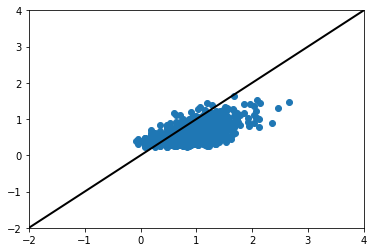

In [61]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 3.2: Test Set Performance

In [62]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model_2 = torch.nn.Sequential(torch.nn.Linear(21, 14),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(14, 9),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(9, 6),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(6, 1))


# Give the new model the old model's parameters
dim_corrected_model_2[(0)].weight = model[(0)].weight
dim_corrected_model_2[(2)].weight = model[(2)].weight
dim_corrected_model_2[(4)].weight = model[(4)].weight
dim_corrected_model_2[(6)].weight = model[(6)].weight

In [63]:
# Get the validation set predictions
y_test_pred = dim_corrected_model_2(test_predictors_Variable)


# Print the loss
loss_fn(y_test_pred,
        test_outcomes_Variable)

Variable containing:
 307.9987
[torch.FloatTensor of size 1]

In [64]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_test_pred_resized = y_test_pred.resize(1609)


# Make the FloatTensor into a numpy.array
y_test_pred_array = y_test_pred_resized.data.numpy()


# Convert back to native units and scale
y_test_pred_array = y_test_pred_array*5.735285 + 6.490682


# Make the numpy.array into a list
y_test_pred_list = y_test_pred_array.tolist()

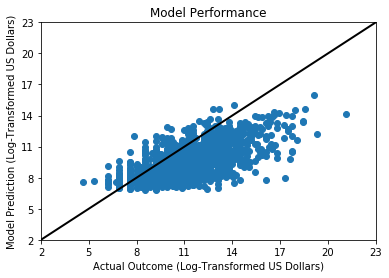

In [65]:
# Plot new predictions versus new data outcomes

plt.scatter(test_outcomes_list, y_test_pred_list)

axes = plt.gca()

axes.set_xlim([2, 23])

axes.set_ylim([2, 23])

axes.set_xticks([2, 5, 8, 11, 14, 17, 20, 23])

axes.set_yticks([2, 5, 8, 11, 14, 17, 20, 23])

plt.plot([2, 23], [2, 23], 'k-', lw=2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [66]:
dim_corrected_model_2[(0)].weight

Parameter containing:

Columns 0 to 9 
 0.0083 -0.0552  0.0046  0.0918 -0.0944 -0.0269  0.0007  0.0522 -0.1607  0.0433
-0.0010 -0.1937 -0.0394 -0.1575  0.0708  0.0934  0.1187 -0.2999  0.0305  0.1831
 0.0818  0.1233  0.1489  0.0581 -0.0876 -0.1544  0.0145 -0.0388 -0.1058 -0.1077
-0.2634  0.1110 -0.1323  0.0380 -0.0593  0.1047 -0.0393  0.0683 -0.1469  0.0105
 0.2430  0.0065 -0.1181  0.1240  0.1715  0.1144 -0.0101 -0.0925  0.0718  0.0934
-0.0430 -0.0108  0.1640 -0.1447 -0.0148  0.0643 -0.0177  0.1460 -0.1452  0.1205
 0.0441  0.0987  0.1221  0.0999  0.2621 -0.1191  0.0640 -0.0627 -0.2125  0.1465
-0.0411  0.1531 -0.0810 -0.1473  0.0468  0.0271  0.1199  0.0557  0.0994 -0.0721
 0.2251 -0.1567  0.2523  0.2394 -0.0204  0.0123 -0.1939 -0.1426  0.2020 -0.0441
-0.0789  0.0593  0.0700 -0.0255  0.0651  0.0015  0.0352 -0.2065 -0.0002  0.1190
 0.0712  0.1220 -0.2214 -0.1141 -0.0584 -0.0239  0.0333 -0.0591  0.2677  0.1324
-0.0721  0.1219  0.1162 -0.0101 -0.3155  0.0301  0.1212  0.1616  0.0488 -0.0625
 

In [67]:
dim_corrected_model_2[(2)].weight

Parameter containing:

Columns 0 to 9 
-0.1529  0.0367  0.0902  0.2610 -0.0531 -0.0712 -0.2251  0.0451  0.1910 -0.0390
 0.2712  0.3376  0.0969  0.0313  0.0087  0.1973 -0.1976  0.2236  0.1375  0.1468
-0.2499  0.0344 -0.0346 -0.2456 -0.0524 -0.1319  0.1176  0.0035  0.0648 -0.0852
 0.2529  0.1076 -0.1334  0.0233 -0.1239  0.1571 -0.0181 -0.1775 -0.0944 -0.0501
 0.3203  0.1195  0.0352 -0.2560 -0.3087  0.1024  0.1687 -0.0267 -0.1156  0.3204
-0.1020  0.0961  0.2054 -0.1990  0.1498 -0.1218 -0.0207  0.2107  0.1431 -0.1521
 0.0424  0.0024  0.2320 -0.0429  0.1194  0.2142  0.2870 -0.0010  0.2555  0.0617
-0.2523  0.0183  0.0988 -0.2213 -0.1442 -0.0356 -0.0654 -0.0060  0.2210  0.0741
 0.1114 -0.0727  0.1297  0.0669  0.0784  0.2107 -0.2155  0.1325  0.0440 -0.1650

Columns 10 to 13 
 0.3086  0.1109 -0.1609  0.0640
-0.0990  0.3067 -0.0331  0.2812
-0.0034 -0.1154 -0.0360 -0.1464
-0.1373  0.1341  0.0329  0.1053
-0.0317  0.0553  0.0873 -0.1785
 0.2447 -0.1239  0.2263 -0.1918
 0.1754  0.0273  0.3466 -0.145

In [68]:
dim_corrected_model_2[(4)].weight

Parameter containing:
-0.2660 -0.0766 -0.1032 -0.0169 -0.3543  0.0422  0.2884 -0.2595 -0.0473
-0.2197 -0.3101  0.1989 -0.0854  0.1087 -0.0663 -0.0717  0.1461  0.0369
-0.0709 -0.2723 -0.1200 -0.0224 -0.0390  0.4049  0.3716 -0.1988  0.0597
 0.0867 -0.4186  0.2558 -0.0333 -0.3724  0.1145  0.2794  0.2409 -0.0792
-0.2396  0.2959  0.0813 -0.0144  0.2413 -0.2660 -0.2501  0.0280 -0.2076
-0.2356 -0.1671 -0.2954 -0.1537 -0.3309  0.2434 -0.2241  0.0654 -0.1310
[torch.FloatTensor of size 6x9]

In [69]:
dim_corrected_model_2[(6)].weight

Parameter containing:
 0.5204  0.3836  0.6089  0.6440  0.3798 -0.3420
[torch.FloatTensor of size 1x6]

## Round 4: Four-Hidden-Layer Neural Network

In [70]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [71]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(21, 14),
                            torch.nn.ReLU(),
                            torch.nn.Linear(14, 9),
                            torch.nn.ReLU(),
                            torch.nn.Linear(9, 6),
                            torch.nn.ReLU(),
                            torch.nn.Linear(6, 4),
                            torch.nn.ReLU(),
                            torch.nn.Linear(4, 1))

In [72]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 5e-6


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    model.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using gradient descent
    for param in model.parameters():
        param.data -= learning_rate * param.grad.data

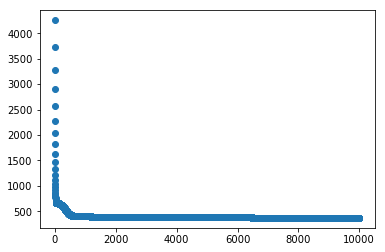

In [73]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors)

In [74]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(4732)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

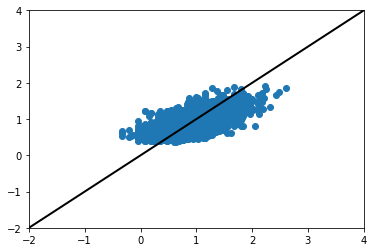

In [75]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 4.1: Validation Set Performance

In [76]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model = torch.nn.Sequential(torch.nn.Linear(21, 14),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(14, 9),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(9, 6),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(6, 4),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(4, 1))


# Give the new model the old model's parameters
dim_corrected_model[(0)].weight = model[(0)].weight
dim_corrected_model[(2)].weight = model[(2)].weight
dim_corrected_model[(4)].weight = model[(4)].weight
dim_corrected_model[(6)].weight = model[(6)].weight
dim_corrected_model[(8)].weight = model[(8)].weight

In [77]:
# Get the validation set predictions
y_valid_pred = dim_corrected_model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 498.4169
[torch.FloatTensor of size 1]

In [78]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(1619)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

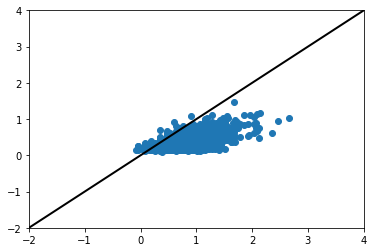

In [79]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 4.2: Test Set Performance

In [80]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model_2 = torch.nn.Sequential(torch.nn.Linear(21, 14),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(14, 9),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(9, 6),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(6, 4),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(4, 1))


# Give the new model the old model's parameters
dim_corrected_model_2[(0)].weight = model[(0)].weight
dim_corrected_model_2[(2)].weight = model[(2)].weight
dim_corrected_model_2[(4)].weight = model[(4)].weight
dim_corrected_model_2[(6)].weight = model[(6)].weight
dim_corrected_model_2[(8)].weight = model[(8)].weight

In [81]:
# Get the validation set predictions
y_test_pred = dim_corrected_model_2(test_predictors_Variable)


# Print the loss
loss_fn(y_test_pred,
        test_outcomes_Variable)

Variable containing:
 434.4147
[torch.FloatTensor of size 1]

In [82]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_test_pred_resized = y_test_pred.resize(1609)


# Make the FloatTensor into a numpy.array
y_test_pred_array = y_test_pred_resized.data.numpy()


# Convert back to native units and scale
y_test_pred_array = y_test_pred_array*5.735285 + 6.490682


# Make the numpy.array into a list
y_test_pred_list = y_test_pred_array.tolist()

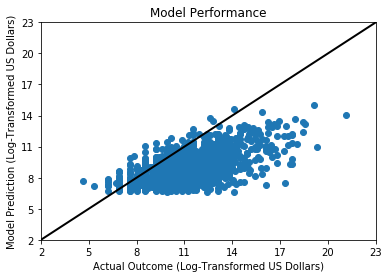

In [83]:
# Plot new predictions versus new data outcomes

plt.scatter(test_outcomes_list, y_test_pred_list)

axes = plt.gca()

axes.set_xlim([2, 23])

axes.set_ylim([2, 23])

axes.set_xticks([2, 5, 8, 11, 14, 17, 20, 23])

axes.set_yticks([2, 5, 8, 11, 14, 17, 20, 23])

plt.plot([2, 23], [2, 23], 'k-', lw=2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [84]:
dim_corrected_model_2[(0)].weight

Parameter containing:

Columns 0 to 9 
 0.1168 -0.1313  0.1640  0.1947  0.2821 -0.0740 -0.0026 -0.0094  0.0825  0.2885
 0.0121 -0.1153  0.0973 -0.0204 -0.0335  0.1093  0.0803  0.1044  0.0781  0.0138
-0.1651  0.0398 -0.0789 -0.1177  0.1812 -0.0973  0.2005  0.0706  0.0512  0.2007
 0.1346  0.1364  0.2773 -0.1147 -0.2417 -0.2115 -0.0351  0.0210  0.0601  0.0946
 0.2776 -0.0645  0.1613 -0.0295  0.2519 -0.0165  0.0536 -0.1149  0.1574  0.2275
 0.0379 -0.0189  0.0906  0.0137  0.0076  0.1149  0.0169  0.2022  0.0346 -0.2282
 0.2328  0.0082 -0.0268 -0.1118  0.0880  0.1812 -0.2124 -0.0888  0.0141  0.1521
 0.0193  0.2004  0.0006  0.2651  0.1215 -0.1286 -0.0661 -0.1397 -0.1269 -0.0064
-0.0015  0.0057  0.0681  0.1494  0.1951 -0.0649 -0.0621  0.0602  0.0313 -0.3342
-0.0643 -0.1403  0.1482  0.2076 -0.2241  0.0304  0.2275 -0.1867 -0.2110  0.1266
 0.3245 -0.1482 -0.0985  0.0053  0.2345 -0.1197  0.0204  0.1790  0.1023  0.1192
 0.1190  0.1801 -0.0196  0.1175  0.1634 -0.0368  0.0806  0.2485  0.1393 -0.1216
 

In [85]:
dim_corrected_model_2[(2)].weight

Parameter containing:

Columns 0 to 9 
 0.1632 -0.2405 -0.0764  0.1363 -0.1457 -0.1515 -0.2227  0.0635 -0.1762 -0.1864
-0.1426  0.0555  0.0239  0.1546  0.3055 -0.0680 -0.0242 -0.1724  0.1353 -0.0245
-0.1919  0.0842  0.1137 -0.0183 -0.0667 -0.1342 -0.2356  0.1299  0.1971 -0.0103
 0.3707 -0.1867 -0.0441 -0.0937  0.3080  0.0081 -0.1562  0.2783  0.1961 -0.0604
-0.0678 -0.2431 -0.0617 -0.1533  0.0566 -0.1953  0.2460 -0.1107  0.1689 -0.2842
 0.2793  0.2033 -0.2011 -0.0369  0.0541 -0.1672 -0.0701 -0.2688  0.0164 -0.2728
-0.0007 -0.1955  0.2870 -0.1747  0.1112  0.0832  0.1774  0.2012  0.1774  0.2067
 0.2464 -0.2397  0.0444 -0.1708  0.0304 -0.2191  0.2561  0.0237 -0.0090  0.0865
 0.1407 -0.0747  0.2406  0.2165  0.1327  0.1496  0.1324  0.2248 -0.1476  0.1396

Columns 10 to 13 
-0.0138  0.1590 -0.1857 -0.2359
 0.2471 -0.2058  0.0158 -0.0492
 0.0509 -0.0947 -0.2348 -0.1120
 0.1392  0.2390  0.0136 -0.1956
 0.1554  0.1702 -0.1544  0.1226
 0.0464 -0.0623  0.0903  0.2653
 0.2607  0.1043 -0.3719 -0.114

In [86]:
dim_corrected_model_2[(4)].weight

Parameter containing:
 0.1939  0.2220 -0.1270 -0.1223  0.2618  0.2199  0.0793  0.1864 -0.2933
-0.0448 -0.3047 -0.0854 -0.2112  0.2631  0.1330 -0.2335  0.2542  0.0290
-0.1424 -0.2984  0.1606  0.4533 -0.2075 -0.1833  0.1992  0.3433  0.2713
-0.3191 -0.3568  0.1263  0.3878  0.1588  0.1162  0.2338  0.2290 -0.2891
 0.1593  0.1521 -0.3169 -0.0502  0.0968  0.1977 -0.0550 -0.2934  0.2015
 0.1708 -0.0035 -0.2196  0.2222  0.2329  0.1419  0.4632 -0.2267  0.0545
[torch.FloatTensor of size 6x9]

In [87]:
dim_corrected_model_2[(6)].weight

Parameter containing:
 0.3488  0.0191  0.1503 -0.2410  0.2351 -0.3098
 0.1378  0.0158  0.4892  0.5105  0.1323  0.5324
 0.0633  0.1946 -0.3837  0.1713 -0.2760 -0.3421
-0.3599  0.2480  0.2186  0.2605  0.1905  0.3025
[torch.FloatTensor of size 4x6]

In [88]:
dim_corrected_model_2[(8)].weight

Parameter containing:
-0.3177  0.7162 -0.0025  0.2673
[torch.FloatTensor of size 1x4]

## Round 5: Five-Hidden-Layer Neural Network

In [89]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [90]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(21, 14),
                            torch.nn.ReLU(),
                            torch.nn.Linear(14, 9),
                            torch.nn.ReLU(),
                            torch.nn.Linear(9, 6),
                            torch.nn.ReLU(),
                            torch.nn.Linear(6, 4),
                            torch.nn.ReLU(),
                            torch.nn.Linear(4, 3),
                            torch.nn.ReLU(),
                            torch.nn.Linear(3, 1))

In [91]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 5e-6


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    model.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using gradient descent
    for param in model.parameters():
        param.data -= learning_rate * param.grad.data

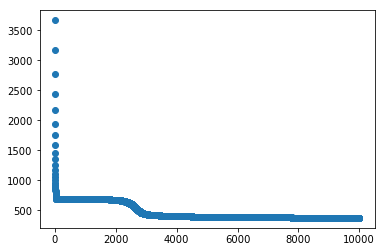

In [92]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors)

In [93]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(4732)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

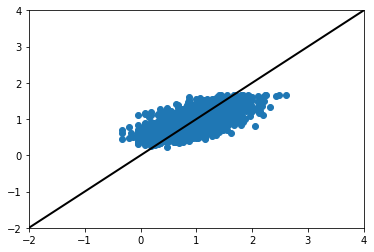

In [94]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 5.1: Validation Set Performance

In [95]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model = torch.nn.Sequential(torch.nn.Linear(21, 14),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(14, 9),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(9, 6),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(6, 4),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(4, 3),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(3, 1))


# Give the new model the old model's parameters
dim_corrected_model[(0)].weight = model[(0)].weight
dim_corrected_model[(2)].weight = model[(2)].weight
dim_corrected_model[(4)].weight = model[(4)].weight
dim_corrected_model[(6)].weight = model[(6)].weight
dim_corrected_model[(8)].weight = model[(8)].weight
dim_corrected_model[(10)].weight = model[(10)].weight

In [96]:
# Get the validation set predictions
y_valid_pred = dim_corrected_model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 6823.8555
[torch.FloatTensor of size 1]

In [97]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(1619)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

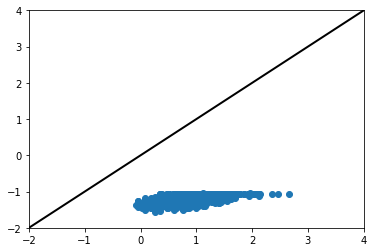

In [98]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 5.2: Test Set Performance

In [99]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model_2 = torch.nn.Sequential(torch.nn.Linear(21, 14),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(14, 9),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(9, 6),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(6, 4),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(4, 3),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(3, 1))


# Give the new model the old model's parameters
dim_corrected_model_2[(0)].weight = model[(0)].weight
dim_corrected_model_2[(2)].weight = model[(2)].weight
dim_corrected_model_2[(4)].weight = model[(4)].weight
dim_corrected_model_2[(6)].weight = model[(6)].weight
dim_corrected_model_2[(8)].weight = model[(8)].weight
dim_corrected_model_2[(10)].weight = model[(10)].weight

In [100]:
# Get the validation set predictions
y_test_pred = dim_corrected_model_2(test_predictors_Variable)


# Print the loss
loss_fn(y_test_pred,
        test_outcomes_Variable)

Variable containing:
 3066.1460
[torch.FloatTensor of size 1]

In [101]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_test_pred_resized = y_test_pred.resize(1609)


# Make the FloatTensor into a numpy.array
y_test_pred_array = y_test_pred_resized.data.numpy()


# Convert back to native units and scale
y_test_pred_array = y_test_pred_array*5.735285 + 6.490682


# Make the numpy.array into a list
y_test_pred_list = y_test_pred_array.tolist()

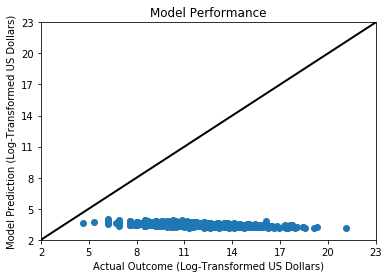

In [102]:
# Plot new predictions versus new data outcomes

plt.scatter(test_outcomes_list, y_test_pred_list)

axes = plt.gca()

axes.set_xlim([2, 23])

axes.set_ylim([2, 23])

axes.set_xticks([2, 5, 8, 11, 14, 17, 20, 23])

axes.set_yticks([2, 5, 8, 11, 14, 17, 20, 23])

plt.plot([2, 23], [2, 23], 'k-', lw=2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [103]:
dim_corrected_model_2[(0)].weight

Parameter containing:

Columns 0 to 9 
 0.1303  0.0083 -0.1740 -0.0310 -0.0034 -0.1195 -0.0689 -0.2011  0.0744 -0.1952
 0.1683  0.0334 -0.2240 -0.2152  0.0072  0.0050 -0.1080  0.1146 -0.0188  0.1848
-0.1398  0.0747  0.1830  0.2319  0.2405 -0.2800 -0.1212 -0.1296  0.0344  0.1405
-0.0163  0.1171  0.0069 -0.0035  0.0310 -0.0621  0.1868 -0.1033 -0.0269  0.0132
 0.0093  0.1980  0.0350 -0.0721 -0.1285 -0.1072 -0.1386  0.0771 -0.0996  0.1035
 0.2698 -0.1194 -0.0744  0.1935  0.3890  0.0315  0.1369  0.1049  0.1392  0.1380
-0.0573  0.0124 -0.0194 -0.1180 -0.0554  0.0330 -0.0183 -0.0336 -0.1753 -0.0812
 0.0069 -0.0383 -0.1756 -0.1004 -0.0910  0.1423 -0.0508 -0.1134 -0.0870 -0.1081
 0.1960 -0.0733 -0.1519 -0.1269  0.1629  0.0089  0.1794 -0.0459 -0.0070 -0.0881
-0.1275 -0.0419 -0.0358 -0.1428 -0.1645 -0.1597 -0.0219 -0.1841  0.0370 -0.0686
-0.1356  0.1329 -0.1171 -0.2571 -0.2427  0.1097  0.0228 -0.1017 -0.1710  0.0495
 0.0933  0.2393 -0.0228  0.1985  0.2160  0.0224 -0.0854 -0.1531  0.0147 -0.1441
-

In [104]:
dim_corrected_model_2[(2)].weight

Parameter containing:

Columns 0 to 9 
-0.0444 -0.0539  0.0683 -0.0513 -0.1215  0.1935 -0.1918  0.2379  0.1305 -0.0935
 0.0462 -0.1010  0.4025  0.0147 -0.2522  0.3519  0.2051 -0.3072  0.2294 -0.1400
-0.1990  0.1957  0.1446  0.0589  0.1527 -0.1194 -0.2534  0.0118 -0.2091 -0.2619
-0.0494  0.1546  0.0693  0.1754  0.1510  0.1126  0.1105  0.1624  0.1662  0.0379
-0.2729  0.0232  0.0674  0.0481  0.1261 -0.2443 -0.0512  0.0683 -0.2628  0.0023
 0.2424  0.1902 -0.0005 -0.2053 -0.1047  0.1225  0.1838  0.1270  0.0093 -0.0284
-0.1958 -0.1072  0.1137 -0.0506 -0.0875  0.1343  0.0148 -0.2234  0.1822 -0.2104
-0.0956 -0.3249 -0.0904  0.0418  0.1901 -0.0461  0.0870  0.2029  0.1656  0.2896
 0.2619  0.2076  0.2372 -0.0397  0.0210 -0.1721 -0.2319  0.1963  0.1992 -0.2306

Columns 10 to 13 
 0.2626  0.0389 -0.0857 -0.2249
-0.2337  0.1286  0.0773  0.0085
 0.1059  0.0598 -0.2627 -0.2235
 0.3068  0.2292  0.0069 -0.1242
 0.1669 -0.1723 -0.1923  0.2215
-0.0028 -0.2620  0.1061  0.2634
 0.2273  0.1397  0.1133  0.204

In [105]:
dim_corrected_model_2[(4)].weight

Parameter containing:
 0.1857 -0.2423  0.1903  0.0624 -0.0337  0.2329 -0.1574 -0.0470  0.1326
 0.0781  0.3685 -0.1670  0.3050 -0.2013  0.1480  0.2260 -0.3198 -0.0378
-0.2706 -0.2422  0.0043  0.3177  0.1792 -0.3220  0.1323  0.3348 -0.0047
 0.3070  0.2458 -0.0126 -0.2859  0.1650  0.2147  0.0525 -0.1783  0.1195
 0.2193 -0.1652 -0.0388 -0.1969 -0.0514 -0.0556 -0.1585  0.0194  0.2200
 0.0253 -0.0153 -0.2595 -0.2227  0.3045 -0.1269 -0.0354  0.3227  0.2895
[torch.FloatTensor of size 6x9]

In [106]:
dim_corrected_model_2[(6)].weight

Parameter containing:
 0.4732 -0.4696  0.5924 -0.1804 -0.2503  0.3530
 0.0880  0.0536  0.0069  0.3352 -0.1282  0.2163
 0.3814  0.4280 -0.2027 -0.1649 -0.1096  0.3340
 0.1473  0.1747  0.2482  0.2423 -0.3169 -0.3980
[torch.FloatTensor of size 4x6]

In [107]:
dim_corrected_model_2[(8)].weight

Parameter containing:
 0.9839  0.2664 -0.1595 -0.1666
-0.4568 -0.3055  0.3993  0.0909
 0.3259 -0.2671  0.0200 -0.4493
[torch.FloatTensor of size 3x4]

In [108]:
dim_corrected_model_2[(10)].weight

Parameter containing:
-0.9978 -0.4968 -0.3957
[torch.FloatTensor of size 1x3]

## Round 6: Six-Hidden-Layer Neural Network

In [109]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [110]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(21, 14),
                            torch.nn.ReLU(),
                            torch.nn.Linear(14, 9),
                            torch.nn.ReLU(),
                            torch.nn.Linear(9, 6),
                            torch.nn.ReLU(),
                            torch.nn.Linear(6, 4),
                            torch.nn.ReLU(),
                            torch.nn.Linear(4, 3),
                            torch.nn.ReLU(),
                            torch.nn.Linear(3, 2),
                            torch.nn.ReLU(),
                            torch.nn.Linear(2, 1))

In [111]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 5e-6


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    model.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using gradient descent
    for param in model.parameters():
        param.data -= learning_rate * param.grad.data

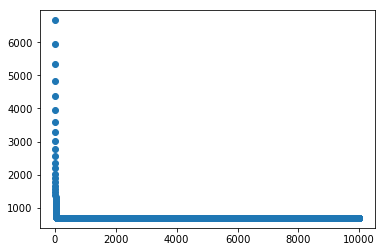

In [112]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors)

In [113]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(4732)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

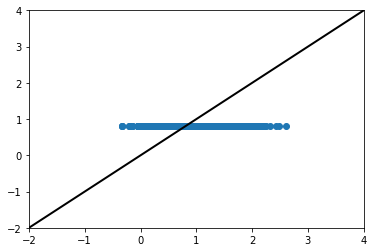

In [114]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 6.1: Validation Set Performance

In [115]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model = torch.nn.Sequential(torch.nn.Linear(21, 14),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(14, 9),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(9, 6),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(6, 4),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(4, 3),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(3, 2),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(2, 1))


# Give the new model the old model's parameters
dim_corrected_model[(0)].weight = model[(0)].weight
dim_corrected_model[(2)].weight = model[(2)].weight
dim_corrected_model[(4)].weight = model[(4)].weight
dim_corrected_model[(6)].weight = model[(6)].weight
dim_corrected_model[(8)].weight = model[(8)].weight
dim_corrected_model[(10)].weight = model[(10)].weight
dim_corrected_model[(12)].weight = model[(12)].weight

In [116]:
# Get the validation set predictions
y_valid_pred = dim_corrected_model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 265.7757
[torch.FloatTensor of size 1]

In [117]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(1619)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

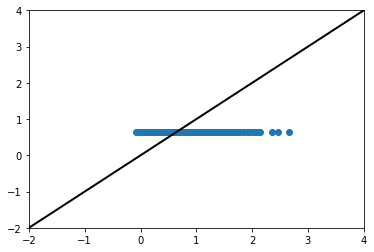

In [118]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 6.2: Test Set Performance

In [119]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model_2 = torch.nn.Sequential(torch.nn.Linear(21, 14),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(14, 9),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(9, 6),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(6, 4),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(4, 3),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(3, 2),
                                            torch.nn.ReLU(),
                                            torch.nn.Linear(2, 1))


# Give the new model the old model's parameters
dim_corrected_model_2[(0)].weight = model[(0)].weight
dim_corrected_model_2[(2)].weight = model[(2)].weight
dim_corrected_model_2[(4)].weight = model[(4)].weight
dim_corrected_model_2[(6)].weight = model[(6)].weight
dim_corrected_model_2[(8)].weight = model[(8)].weight
dim_corrected_model_2[(10)].weight = model[(10)].weight
dim_corrected_model_2[(12)].weight = model[(12)].weight

In [120]:
# Get the validation set predictions
y_test_pred = dim_corrected_model_2(test_predictors_Variable)


# Print the loss
loss_fn(y_test_pred,
        test_outcomes_Variable)

Variable containing:
 888.8100
[torch.FloatTensor of size 1]

In [121]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_test_pred_resized = y_test_pred.resize(1609)


# Make the FloatTensor into a numpy.array
y_test_pred_array = y_test_pred_resized.data.numpy()


# Convert back to native units and scale
y_test_pred_array = y_test_pred_array*5.735285 + 6.490682


# Make the numpy.array into a list
y_test_pred_list = y_test_pred_array.tolist()

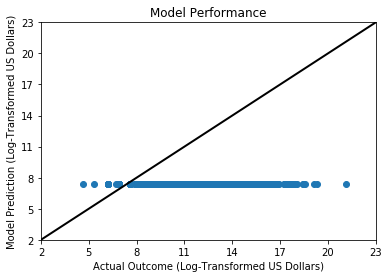

In [122]:
# Plot new predictions versus new data outcomes

plt.scatter(test_outcomes_list, y_test_pred_list)

axes = plt.gca()

axes.set_xlim([2, 23])

axes.set_ylim([2, 23])

axes.set_xticks([2, 5, 8, 11, 14, 17, 20, 23])

axes.set_yticks([2, 5, 8, 11, 14, 17, 20, 23])

plt.plot([2, 23], [2, 23], 'k-', lw=2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [123]:
dim_corrected_model_2[(0)].weight

Parameter containing:

Columns 0 to 9 
 0.1430  0.0787  0.0698 -0.1883 -0.1909 -0.0686  0.0378 -0.1718  0.1719 -0.2162
-0.0628  0.1864  0.0421  0.0417  0.0163  0.1511  0.1437  0.2107 -0.1259  0.0577
-0.0375  0.1865  0.0364  0.0917 -0.1109  0.1084 -0.0805 -0.2177 -0.1217  0.1202
-0.1058 -0.0143 -0.0183  0.1648  0.0650 -0.0563 -0.0994  0.0656  0.0825 -0.1331
-0.0819  0.1177  0.1301  0.1486  0.1215  0.1297  0.1228 -0.0315  0.0664  0.2035
 0.2048 -0.0955 -0.1485  0.1123  0.0812 -0.2012 -0.0711  0.0655  0.1508  0.1607
 0.1478  0.0460 -0.0710 -0.0415 -0.0628  0.1732  0.1287  0.1951 -0.1861 -0.1415
-0.0360  0.2096 -0.0839  0.1198 -0.1067  0.1255 -0.0556 -0.0246  0.0379  0.0485
 0.1290 -0.1655  0.1444 -0.0612 -0.0122 -0.0069 -0.2114  0.2150  0.0944  0.0522
 0.1616  0.1647  0.0451 -0.0488 -0.1359 -0.0687  0.0858  0.0680  0.0813 -0.1577
-0.1645 -0.0527  0.1216  0.0188 -0.1241 -0.0145 -0.1294  0.1800  0.1197  0.0197
-0.0852 -0.1601  0.1240  0.0878 -0.0294  0.0570 -0.0123 -0.2076 -0.0803  0.1991
 

In [124]:
dim_corrected_model_2[(2)].weight

Parameter containing:

Columns 0 to 9 
 0.0206 -0.1393 -0.1712 -0.1500  0.2173  0.0681  0.1475 -0.0885  0.2328 -0.2666
 0.2508 -0.2231 -0.0689 -0.2158 -0.1589 -0.2618 -0.0141  0.1757  0.1887  0.1159
-0.1482 -0.2471  0.1631 -0.0201  0.2645 -0.1320  0.0091  0.1666  0.0155  0.1004
-0.1013 -0.2430 -0.2032 -0.0185  0.0413  0.0807 -0.0395 -0.0008 -0.1574 -0.2635
-0.0277 -0.2266  0.0897 -0.2005 -0.1906  0.0863  0.1465 -0.1874 -0.1738  0.1814
 0.1810 -0.1070 -0.2621  0.1213 -0.2297  0.1983  0.1101 -0.1407 -0.2612 -0.1614
-0.1612 -0.1340 -0.1674  0.0326  0.2060  0.2104 -0.1556 -0.1454  0.1982  0.0095
-0.1799  0.0197 -0.2660 -0.1053 -0.0234 -0.1660  0.1452  0.1630 -0.1823  0.1852
 0.0758  0.1826 -0.1498 -0.1296  0.2235 -0.0927 -0.1550  0.0181 -0.0196 -0.1732

Columns 10 to 13 
-0.1464  0.0202 -0.0674  0.2410
 0.0489 -0.0189 -0.1713  0.1246
-0.0849  0.2485 -0.1896  0.1107
-0.0604 -0.1049  0.2385  0.0367
 0.1404  0.2278 -0.0594  0.0879
 0.0883  0.2370  0.2495 -0.0827
 0.2005  0.1596  0.1339  0.093

In [125]:
dim_corrected_model_2[(4)].weight

Parameter containing:
 0.1079  0.0353  0.0102  0.0145 -0.0467 -0.2929 -0.1975  0.0579  0.0203
 0.1517  0.2233 -0.0291  0.1578 -0.0400  0.2287  0.1249 -0.1955  0.1421
-0.2366  0.2166  0.3167 -0.2582 -0.3326 -0.0116  0.2809  0.1472 -0.2602
 0.1226 -0.1903  0.1855  0.0339 -0.0615  0.3000 -0.1380 -0.2762 -0.2850
 0.1670 -0.2119  0.0593  0.1177 -0.2523  0.1668 -0.1660 -0.1483  0.1810
 0.1099  0.2698  0.2942 -0.0218  0.0500 -0.2419 -0.2534 -0.1031 -0.0963
[torch.FloatTensor of size 6x9]

In [126]:
dim_corrected_model_2[(6)].weight

Parameter containing:
 0.2384  0.2015  0.2987  0.3617 -0.3904  0.3351
 0.0245  0.3961  0.1005 -0.3847 -0.2511  0.4061
-0.2877  0.1023 -0.2343 -0.2639 -0.0845  0.1166
-0.1130 -0.4049  0.0848  0.3923  0.1521  0.2577
[torch.FloatTensor of size 4x6]

In [127]:
dim_corrected_model_2[(8)].weight

Parameter containing:
-0.1161  0.3885 -0.1692  0.3629
 0.0296  0.1306  0.3646 -0.3546
 0.2528  0.1769  0.4656 -0.1361
[torch.FloatTensor of size 3x4]

In [128]:
dim_corrected_model_2[(10)].weight

Parameter containing:
-0.0641 -0.1928 -0.0071
 0.0870  0.0448  0.3979
[torch.FloatTensor of size 2x3]

In [129]:
dim_corrected_model_2[(12)].weight

Parameter containing:
-0.1115 -0.0337
[torch.FloatTensor of size 1x2]

## Round 7: Linear Regression

In [130]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [131]:
# Make the neural network - really a regression
model = torch.nn.Sequential(torch.nn.Linear(21, 1))

In [132]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 4e-6


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    model.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using gradient descent
    for param in model.parameters():
        param.data -= learning_rate * param.grad.data

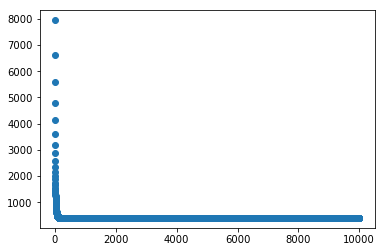

In [133]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors)

In [134]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(4732)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

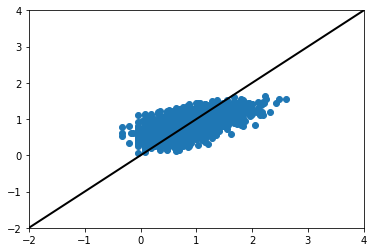

In [135]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 7.1: Validation Set Performance

In [136]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model = torch.nn.Sequential(torch.nn.Linear(21, 1))


# Give the new model the old model's parameters
dim_corrected_model[(0)].weight = model[(0)].weight

In [137]:
# Get the validation set predictions
y_valid_pred = dim_corrected_model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 562.0555
[torch.FloatTensor of size 1]

In [138]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(1619)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

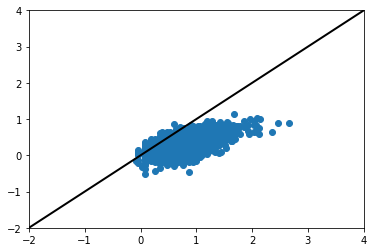

In [139]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 7.2: Test Set Performance

In [140]:
# Have to make a new model and give it the train_model parameters to fix structure problem
dim_corrected_model_2 = torch.nn.Sequential(torch.nn.Linear(21, 1))


# Give the new model the old model's parameters
dim_corrected_model_2[(0)].weight = model[(0)].weight

In [141]:
# Get the validation set predictions
y_test_pred = dim_corrected_model_2(test_predictors_Variable)


# Print the loss
loss_fn(y_test_pred,
        test_outcomes_Variable)

Variable containing:
 593.9808
[torch.FloatTensor of size 1]

In [142]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_test_pred_resized = y_test_pred.resize(1609)


# Make the FloatTensor into a numpy.array
y_test_pred_array = y_test_pred_resized.data.numpy()


# Convert back to native units and scale
y_test_pred_array = y_test_pred_array*5.735285 + 6.490682


# Make the numpy.array into a list
y_test_pred_list = y_test_pred_array.tolist()

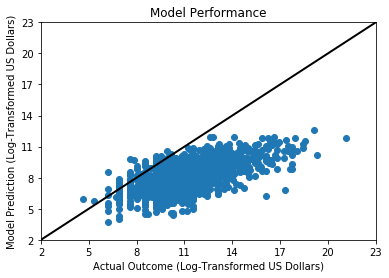

In [143]:
# Plot new predictions versus new data outcomes

plt.scatter(test_outcomes_list, y_test_pred_list)

axes = plt.gca()

axes.set_xlim([2, 23])

axes.set_ylim([2, 23])

axes.set_xticks([2, 5, 8, 11, 14, 17, 20, 23])

axes.set_yticks([2, 5, 8, 11, 14, 17, 20, 23])

plt.plot([2, 23], [2, 23], 'k-', lw=2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [144]:
dim_corrected_model_2[(0)].weight

Parameter containing:

Columns 0 to 9 
 0.0311 -0.0016  0.0051  0.1184  0.1516 -0.0286  0.0044  0.0161  0.0487  0.0056

Columns 10 to 19 
 0.0373  0.0038  0.0071 -0.0127  0.0073 -0.0110 -0.0096  0.0160 -0.0054  0.0040

Columns 20 to 20 
 0.0051
[torch.FloatTensor of size 1x21]